## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = '../train_data/snapshots/resnet50_512_07_out.h5'
#os.path.join('..', 'snapshots', 'resnet_out_05.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.load_model(model_path, backbone_name='resnet50', convert=True)

# print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'pneumania'}

/usr/local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

processing time:  8.879826068878174


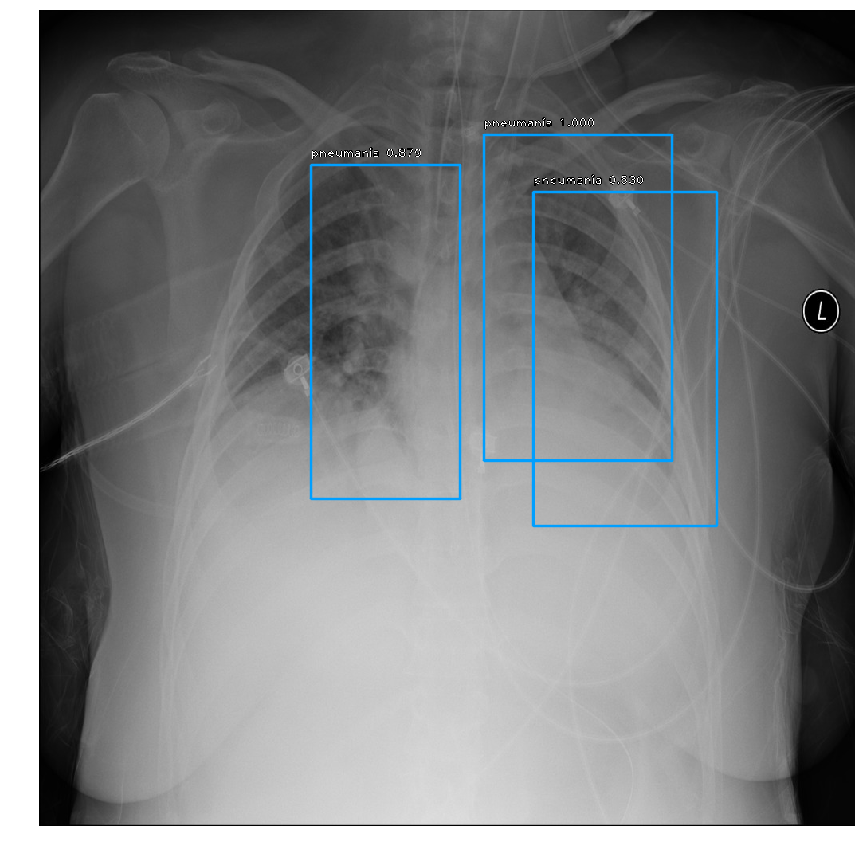

In [3]:
# load image
image = read_image_bgr('../train_data/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [4]:
def review_image(image_path, threshold):
    # load image
    image = read_image_bgr(image_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
#     print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale
    # print(boxes, scores, labels)
    output = []
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < threshold:
            break

#         color = label_color(label)

        b = box.astype(int)
#         draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
#         print(caption, b)
        output.append({'image': image_path, 'box': b, 'score':score, 'label': labels_to_names[label]})
#         draw_caption(draw, b, caption)
#     print("Completed")
    return output

In [5]:
xrays = (os.listdir("../train_data/stage_1_train_images"))
#print(xrays)

In [6]:
def prepare_output_line(patient_id, result):
    boxes = []
    for detection in result:
        boxes.append('{} {}'.format(detection['score'], " ".join(map(str, detection['box']))))
    # Row for CSV file:
    # patient_id,prediction_string
    return '{},{}'.format(patient_id, ' '.join(boxes))


In [7]:
import csv
train_data = {}
with open('../train_data/stage_1_train_labels.csv', newline='') as csvfile:
    csv_source = csv.reader(csvfile, delimiter=',', quotechar='|')
    row = csv_source.__next__()
    for row in csv_source:
        if row[5] != '1':
            continue
        patient_id = row.pop(0)
        if not train_data.get(patient_id):
            train_data[patient_id] = []
        train_data[patient_id].append(row)

In [8]:
TP = 0
FP = 0
FN = 0

def check_result(patient_id, result):
    global train_data, TP, FP, FN
    if train_data.get(patient_id):
        # Result should be positive.
        if result:
            TP+=1
#             print("TP")
        else:
            FN+=1
#             print("FN")
    else:
        # Result should be negative.
        if result:
            FP+=1
#             print("FP")
            
# check_result(14,['qwe'])
print(TP, FP, FN)

0 0 0


In [ ]:
output_filepath = '../train_data/submission3.csv'
i = 0
with open(output_filepath, 'w') as output_file:
    for xray in xrays:
        i+=1
        if i < 800:
            continue
        if i > 2800:
            break
        if (i % 10) == 0:
            print(TP, FP, FN)
#             continue
        patient_id = os.path.splitext(os.path.basename(xray))[0]
        #print(patient_id)
        image_path = '../train_data/stage_1_train_images/{}'.format(xray)
        result = review_image(image_path, threshold = 0.5)
        
        loss = check_result(patient_id, result)
#         print(result)
        
        # Write result to the output_file.
        out_str = '{},'.format(patient_id)
        if result:
            out_str = prepare_output_line(patient_id, result)
#             break
        output_file.write(out_str+"\n")
    #     break
    

0 0 0
2 4 0
4 8 0
5 12 0
9 14 0
11 16 0
13 21 0
14 24 0
16 30 0
